# Web and Social Media Analytics

## Import libaries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import re
import nltk
from nltk import corpus,tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer,porter
from wordcloud import STOPWORDS
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc

## Load dataset

In [2]:
data = pd.read_csv('datasets/hotstar_allreview.csv')


In [3]:
# Display the first few rows of the dataset
data.head()

,ID,UserName,Created_Date,Reviews,Lower_Case_Reviews,Sentiment_Manual_BP,Sentiment_Manual,Review_Length,DataSource,Year,Month,Date,Sentiment_Polarity
0,1,NaN,8/10/2017,Hh,hh,Negative,Negative,2,Google_PlayStore,2017,8,10,Neutral
1,2,NaN,8/11/2017,No,no,Negative,Negative,2,Google_PlayStore,2017,8,11,Neutral
2,3,asadynwa,8/12/2017,@hotstar_helps during paymnt for premium subsc...,@hotstar_helps during paymnt for premium subsc...,Help,Negative,140,Twitter,2017,8,12,Negative
3,4,jineshroxx,8/11/2017,@hotstartweets I am currently on Jio network a...,@hotstartweets i am currently on jio network a...,Help,Negative,140,Twitter,2017,8,11,Positive
4,5,YaminiSachar,8/5/2017,@hotstartweets the episodes of Sarabhai vs Sar...,@hotstartweets the episodes of sarabhai vs sar...,Help,Negative,140,Twitter,2017,8,5,Neutral


In [4]:
# Display the shape of the dataset
data.shape

(5053, 13)

In [5]:
# Show information about the dataset (columns, data types, etc.)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5053 entries, 0 to 5052
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   5053 non-null   int64 
 1   UserName             4331 non-null   object
 2   Created_Date         5053 non-null   object
 3   Reviews              5053 non-null   object
 4   Lower_Case_Reviews   5053 non-null   object
 5   Sentiment_Manual_BP  5053 non-null   object
 6   Sentiment_Manual     5053 non-null   object
 7   Review_Length        5053 non-null   int64 
 8   DataSource           5053 non-null   object
 9   Year                 5053 non-null   int64 
 10  Month                5053 non-null   int64 
 11  Date                 5053 non-null   int64 
 12  Sentiment_Polarity   5053 non-null   object
dtypes: int64(5), object(8)
memory usage: 513.3+ KB


In [6]:
# Count the occurrences of each sentiment
data.Sentiment_Manual.value_counts()

Sentiment_Manual
Neutral     1738
Positive    1733
Negative    1582
Name: count, dtype: int64

In [7]:
# Count the occurrences of each data source
data.DataSource.value_counts()

DataSource
Twitter             2826
Google_PlayStore    2227
Name: count, dtype: int64

In [8]:
# Calculate the percentage distribution of data sources
data.DataSource.value_counts() / data.DataSource.size * 100

DataSource
Twitter             55.927172
Google_PlayStore    44.072828
Name: count, dtype: float64

In [9]:
# Create a pivot table showing the percentage distribution of sentiments per data source
pd.pivot_table(data, index='Sentiment_Manual', columns='DataSource', values="ID", aggfunc='count') / data.DataSource.size * 100

DataSource,Google_PlayStore,Twitter
Sentiment_Manual,,
Negative,12.923016,18.385118
Neutral,5.125668,29.269741
Positive,26.024144,8.272313


In [10]:
# Group by 'Sentiment_Manual' and 'DataSource', then count the occurrences
pivot_data = data.groupby(['Sentiment_Manual', 'DataSource']).size().unstack(fill_value=0)

# Calculate the percentage
percentage = (pivot_data / len(data)) * 100

percentage

DataSource,Google_PlayStore,Twitter
Sentiment_Manual,,
Negative,12.923016,18.385118
Neutral,5.125668,29.269741
Positive,26.024144,8.272313


# Data Visulization

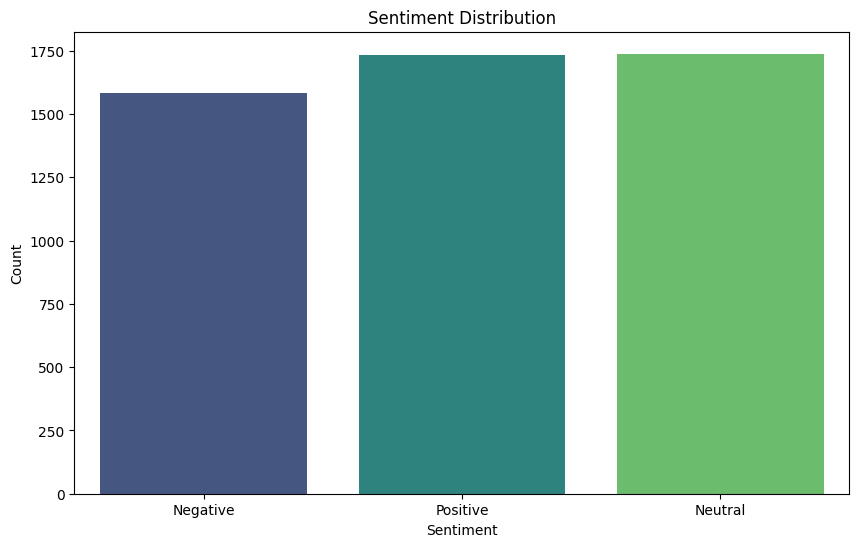

In [11]:
# Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Sentiment_Manual', data=data, palette='viridis')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


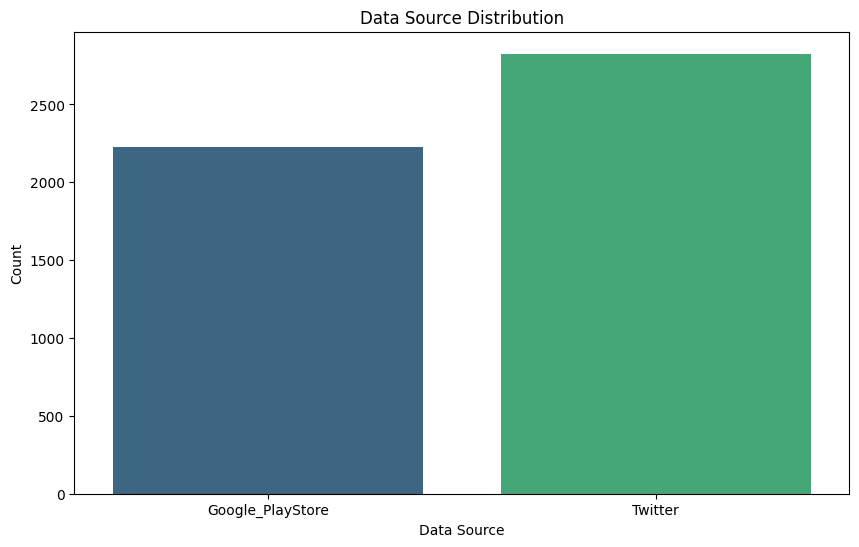

In [12]:
# Data Source Distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='DataSource', data=data, palette='viridis')
plt.title('Data Source Distribution')
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.show()

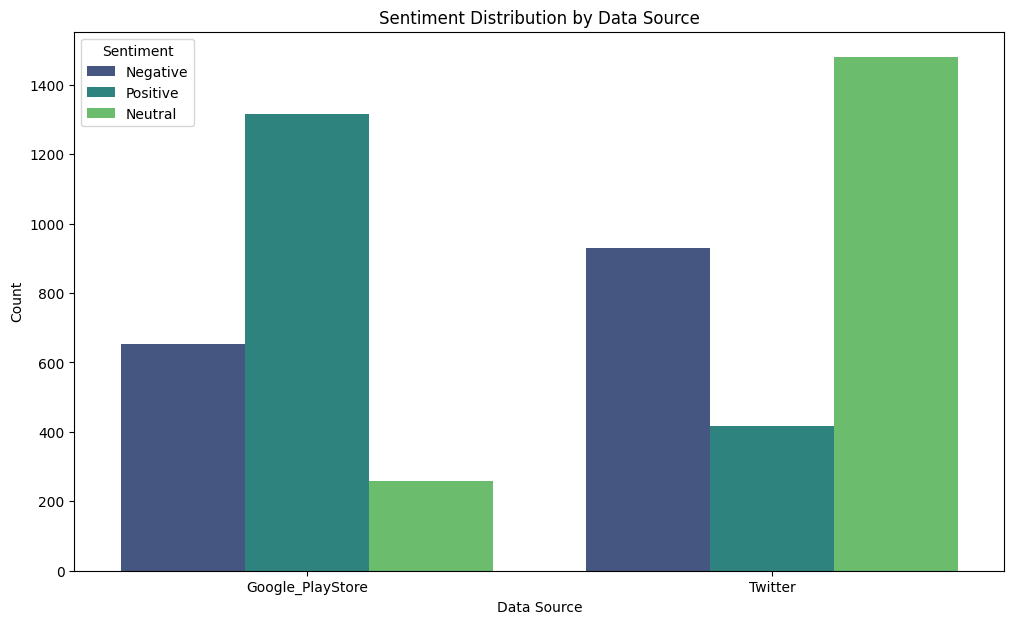

In [13]:
#Sentiment Distribution by Data Source
plt.figure(figsize=(12, 7))
sns.countplot(x='DataSource', hue='Sentiment_Manual', data=data, palette='viridis')
plt.title('Sentiment Distribution by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Count')
plt.legend(title='Sentiment')
plt.show()


## Data Cleaning

In [14]:
review_data=data[['Lower_Case_Reviews','DataSource','Sentiment_Manual']]
review_data.head()

,Lower_Case_Reviews,DataSource,Sentiment_Manual
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [15]:
review_data.columns=['Reviews','Source','Sentiment']
review_data.head()

,Reviews,Source,Sentiment
0,hh,Google_PlayStore,Negative
1,no,Google_PlayStore,Negative
2,@hotstar_helps during paymnt for premium subsc...,Twitter,Negative
3,@hotstartweets i am currently on jio network a...,Twitter,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,Twitter,Negative


In [16]:
review_data.describe()

,Reviews,Source,Sentiment
count,5053,5053,5053
unique,5053,2,3
top,hh,Twitter,Neutral
freq,1,2826,1738


In [17]:
review_data.Source.value_counts()

Source
Twitter             2826
Google_PlayStore    2227
Name: count, dtype: int64

In [18]:
# Convert the 'Source' column to categorical codes
review_data['Source'] = review_data['Source'].astype('category').cat.codes

C:\Users\shank\AppData\Local\Temp\ipykernel_22928\3824541969.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['Source'] = review_data['Source'].astype('category').cat.codes


In [19]:
review_data.head()

,Reviews,Source,Sentiment
0,hh,0,Negative
1,no,0,Negative
2,@hotstar_helps during paymnt for premium subsc...,1,Negative
3,@hotstartweets i am currently on jio network a...,1,Negative
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative


In [21]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [22]:
# Define stop words and punctuation for text processing
punctuation = list(string.punctuation)
stop_words = stopwords.words('english')


In [23]:
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [24]:
# Define regular expression patterns for cleaning the text
re_pattern = """@[a-zA-Z0-9_:]+|b['"]rt|[\\d]+[a-zA-Z_+='?]+[\\d]+[\\d]+|[a-zA-Z_*+=]+[\\d]+[a-zA-Z_*+-=]+|[\\d]+"""
re_pattern = re_pattern + """|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt"""


In [25]:
# Apply the regex pattern to clean the reviews
review_text = [re.sub(pattern=re_pattern,string=text,repl="")
              for text in review_data.Reviews.map(str).values
              ]

In [26]:
re_pattern

'@[a-zA-Z0-9_:]+|b[\'"]rt|[\\d]+[a-zA-Z_+=\'?]+[\\d]+[\\d]+|[a-zA-Z_*+=]+[\\d]+[a-zA-Z_*+-=]+|[\\d]+|https:+[a-zA-Z0-9/._+-=]+|&amp;|rt'

In [27]:
review_text

['hh',
 'no',
 ' during paymnt for premium subscription the transaction failed twice but i have not received refund for one of the transaction',
 ' i am currently on jio network and would like to know whether i will be able to watch epl telecasted on star spos select hd',
 ' the episodes of sarabhai vs sarabhai season  are not downloadable m not able to watch them offline please do smthng about it',
 ' not able  watch the latest episode of got on the app doesn t allow to take the screenshot of the error help to resolve asap',
 'please allow rupay or maestro payment gateways for premium membership i mean paytm works but thru debit cards would be great ',
 ' why today s epi of #lovekahaiintezaar nt available on available now it was in d morning now showing nt available due expiry',
 ' #hotstarfraud i paid for the subscription before  july havent received any cashback which was  specified for hdfc card',
 ' i have a premium accnt at hotstar but now it is showing tht i m not a premium memb

In [28]:
review_text[3]

' i am currently on jio network and would like to know whether i will be able to watch epl telecasted on star spos select hd'

In [29]:
data.Reviews[3]

'@hotstartweets I am currently on Jio network and would like to know whether I will be able to watch EPL telecasted on Star Sports Select HD1'

In [30]:
# Perform further cleaning by removing stop words and punctuation
review_data_cleaned = []

for review in review_text:
    stop_free1= " ".join([txt for txt in review.lower().split() if txt not in stop_words])
    stop_free2 = " ".join(txt for txt in stop_free1.lower().split() if txt not in STOPWORDS)
    punct_free=" ".join([txt for txt in stop_free2.lower().split() if txt not in punctuation])
    review_data_cleaned.append(punct_free)

In [31]:
review_data_cleaned[7]

'today epi #lovekahaiintezaar nt available available morning showing nt available due expiry'

In [32]:
# For removing hashtag
review_data_cleaned_final=[]

for rm in review_data_cleaned:
    final_words= rm.replace('#','')
    review_data_cleaned_final.append(final_words)

In [33]:
review_data_cleaned_final[57]

'need buy rs premier league pack compulsory watch pl matches already premium pack activated'

In [34]:
# Create a cleaned corpus by removing non-alphabetic characters
corpus =[]
for i in range(len(review_data_cleaned)):
    review=re.sub('[^a-zA-Z]',' ',review_data_cleaned[i])
    review="".join(review)
    corpus.append(review)

In [35]:
corpus

['hh',
 '',
 'paymnt premium subscription transaction failed twice received refund one transaction',
 'currently jio network know whether able watch epl telecasted star spos select hd',
 'episodes sarabhai vs sarabhai season downloadable able watch offline please smthng',
 'able watch latest episode got app allow take screenshot error help resolve asap',
 'please allow rupay maestro payment gateways premium membership mean paytm works thru debit cards great',
 'today epi  lovekahaiintezaar nt available available morning showing nt available due expiry',
 ' hotstarfraud paid subscription july havent received cashback specified hdfc card',
 'premium accnt hotstar showing tht premium member u pls chk',
 'seeing blank page terms amp conditions hdfc bank cashback offer hotstar premium membership please help',
 'sir please allow us download videos ur app present option allow us dwnld mre videos due ltd space',
 'hi pl tab spos homepage isl bundesliga search team name stream pls look',
 'unab

In [36]:
#Applying Lemmatization

wd = WordNetLemmatizer()

review_data_cleaned_final_output=[]
for rdc in review_data_cleaned_final:
    clean_review=" ".join(wd.lemmatize(word) for word in rdc.split())
    review_data_cleaned_final_output.append(clean_review)

In [37]:
review_data_cleaned_final_output

['hh',
 '',
 'paymnt premium subscription transaction failed twice received refund one transaction',
 'currently jio network know whether able watch epl telecasted star spos select hd',
 'episode sarabhai v sarabhai season downloadable able watch offline please smthng',
 'able watch latest episode got app allow take screenshot error help resolve asap',
 'please allow rupay maestro payment gateway premium membership mean paytm work thru debit card great',
 'today epi lovekahaiintezaar nt available available morning showing nt available due expiry',
 'hotstarfraud paid subscription july havent received cashback specified hdfc card',
 'premium accnt hotstar showing tht premium member u pls chk',
 'seeing blank page term amp condition hdfc bank cashback offer hotstar premium membership please help',
 'sir please allow u download video ur app present option allow u dwnld mre video due ltd space',
 'hi pl tab spos homepage isl bundesliga search team name stream pls look',
 'unable watch star

In [38]:
# Add the cleaned reviews to the dataframe
review_data['clean_review']=review_data_cleaned_final_output

C:\Users\shank\AppData\Local\Temp\ipykernel_22928\3682031011.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_data['clean_review']=review_data_cleaned_final_output


In [39]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [40]:
# Split the data into training and test sets

x_train, x_test,y_train,y_test=train_test_split(review_data['clean_review'],
                                                review_data['Sentiment'],test_size=0.2,
                                                random_state=42,
                                                stratify=review_data['Sentiment'])

In [41]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)



(4042,)
(1011,)
(4042,)
(1011,)


# Feature Extraction- Bag of Words

In [42]:
# vectorize the text data using CountVectorizer

vectorizer = CountVectorizer(binary=True).fit(x_train)
x_train_vectorized=vectorizer.transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

In [43]:
# Output the vectorized test data (sparse matrix)
print(x_test_vectorized)

  (0, 1394)	1
  (0, 1545)	1
  (0, 1773)	1
  (0, 1840)	1
  (0, 2371)	1
  (0, 2978)	1
  (1, 1069)	1
  (1, 1394)	1
  (1, 3897)	1
  (2, 64)	1
  (2, 254)	1
  (2, 2178)	1
  (2, 2576)	1
  (2, 2987)	1
  (3, 196)	1
  (3, 398)	1
  (3, 641)	1
  (3, 1816)	1
  (3, 2356)	1
  (3, 2974)	1
  (3, 3803)	1
  (3, 3828)	1
  (3, 3963)	1
  (3, 4174)	1
  (4, 196)	1
  :	:
  (1002, 508)	1
  (1003, 1556)	1
  (1003, 4190)	1
  (1003, 4386)	1
  (1004, 2987)	1
  (1005, 1394)	1
  (1005, 1683)	1
  (1005, 1825)	1
  (1005, 2598)	1
  (1005, 2978)	1
  (1005, 4079)	1
  (1005, 4763)	1
  (1006, 894)	1
  (1006, 1368)	1
  (1006, 1394)	1
  (1006, 1978)	1
  (1006, 2196)	1
  (1006, 3311)	1
  (1006, 4794)	1
  (1006, 4902)	1
  (1007, 254)	1
  (1009, 704)	1
  (1009, 1500)	1
  (1009, 3020)	1
  (1009, 3363)	1


In [44]:
# Print the feature names (vocabulary)
print(vectorizer.get_feature_names_out())

['aa' 'aaaaaand' 'aaaaah' ... 'zinab' 'zindabad' 'znmd']


In [45]:
# Convert the vectorized training data to a DataFrame for easy viewing
pd.DataFrame(x_train_vectorized.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4039,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4040,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
#Convert the vectorized test data to a DataFrame for easy viewing
pd.DataFrame(x_test_vectorized.toarray())


,0,1,2,3,4,5,6,7,8,9,...,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Model Building

### Naive Bayes

In [47]:
## Model Building - Naive Bayes
naive_bayes_multi=MultinomialNB().fit(x_train_vectorized,y_train)

In [48]:
# Evaluate the Naive Bayes model
print(naive_bayes_multi.score(x_train_vectorized,y_train))
print(naive_bayes_multi.score(x_test_vectorized,y_test))


0.880257298367145
0.7161226508407518


In [49]:
# Print the log probability of each feature given a class
# This gives insight into how the model weights the features for each class
print(naive_bayes_multi.feature_log_prob_)

[[-8.83789893 -9.53104611 -9.53104611 ... -8.83789893 -8.83789893
  -8.83789893]
 [-9.64134326 -8.94819608 -8.94819608 ... -9.64134326 -9.64134326
  -9.64134326]
 [-9.25416585 -9.25416585 -9.25416585 ... -9.25416585 -9.25416585
  -9.25416585]]


In [50]:
# Predict the labels for the training data and test data
predict_train = naive_bayes_multi.predict(x_train_vectorized)
predict_test = naive_bayes_multi.predict(x_test_vectorized)
                                        

In [51]:
predict_train

array(['Positive', 'Negative', 'Neutral', ..., 'Negative', 'Negative',
       'Negative'], dtype='<U8')

In [52]:
predict_test

array(['Negative', 'Positive', 'Positive', ..., 'Neutral', 'Neutral',
       'Neutral'], dtype='<U8')

In [53]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [54]:
y_train_new= get_num(y_train)
y_test_new=get_num(y_test)
predict_train_new=get_num(predict_train)
predict_test_new=get_num(predict_test)

In [55]:
y_train_new

,Sentiment,y_label
2669,Positive,1
4312,Negative,2
2512,Neutral,0
2722,Positive,1
3254,Positive,1
...,...,...
350,Negative,2
4952,Positive,1
958,Negative,2
67,Negative,2


In [56]:
# Output the classification report
print(classification_report(y_train_new['y_label'],predict_train_new['y_label']))
print()
print(classification_report(y_test_new['y_label'],predict_test_new['y_label']))


              precision    recall  f1-score   support

           0       0.91      0.82      0.86      1390
           1       0.90      0.91      0.91      1386
           2       0.83      0.91      0.87      1266

    accuracy                           0.88      4042
   macro avg       0.88      0.88      0.88      4042
weighted avg       0.88      0.88      0.88      4042


              precision    recall  f1-score   support

           0       0.68      0.66      0.67       348
           1       0.80      0.73      0.76       347
           2       0.68      0.76      0.72       316

    accuracy                           0.72      1011
   macro avg       0.72      0.72      0.72      1011
weighted avg       0.72      0.72      0.72      1011



In [57]:
# Output the classification accuracy score
print(accuracy_score(y_train_new['y_label'],predict_train_new['y_label']))
print()
print(accuracy_score(y_test_new['y_label'],predict_test_new['y_label']))


0.880257298367145

0.7161226508407518


# RandomForestClassifier

In [58]:
# Model Building - RandomForestClassifier
rf_model = RandomForestClassifier().fit(x_train_vectorized,y_train)

In [59]:
print(rf_model.score(x_train_vectorized,y_train))
print(rf_model.score(x_test_vectorized,y_test))

0.9903513112320633
0.7032640949554896


In [60]:
predict_train1 = rf_model.predict(x_train_vectorized)
predict_test1 = rf_model.predict(x_test_vectorized)
                                        

In [61]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [62]:
y_train_new1= get_num(y_train)
y_test_new1=get_num(y_test)
predict_train_new1=get_num(predict_train1)
predict_test_new1=get_num(predict_test1)

In [63]:
print(classification_report(y_train_new1['y_label'],predict_train_new1['y_label']))
print()
print(classification_report(y_test_new1['y_label'],predict_test_new1['y_label']))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1390
           1       0.99      0.99      0.99      1386
           2       1.00      0.99      0.99      1266

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042


              precision    recall  f1-score   support

           0       0.66      0.70      0.68       348
           1       0.75      0.75      0.75       347
           2       0.70      0.66      0.68       316

    accuracy                           0.70      1011
   macro avg       0.70      0.70      0.70      1011
weighted avg       0.70      0.70      0.70      1011



In [64]:
print(accuracy_score(y_train_new1['y_label'],predict_train_new1['y_label']))
print()
print(accuracy_score(y_test_new1['y_label'],predict_test_new1['y_label']))


0.9903513112320633

0.7032640949554896


# Apply K-fold method

In [65]:
from sklearn.model_selection import cross_val_score
training_accuracy=cross_val_score(rf_model,x_train_vectorized,y_train,cv=10)
print(training_accuracy.mean())

0.7382514362547365


# XGBoostClassifier

In [66]:
def get_num(data):
    data_new=pd.DataFrame(data,columns=['Sentiment'])
    data_new['y_label']=np.where(data_new['Sentiment']=='Neutral',0,
                                np.where(data_new['Sentiment']=='Positive',1,2))
    return data_new

In [67]:
y_train_new2= get_num(y_train)
y_test_new2=get_num(y_test)
predict_train_new2=get_num(predict_train1)
predict_test_new2=get_num(predict_test1)

In [68]:
y_train_new2

,Sentiment,y_label
2669,Positive,1
4312,Negative,2
2512,Neutral,0
2722,Positive,1
3254,Positive,1
...,...,...
350,Negative,2
4952,Positive,1
958,Negative,2
67,Negative,2


In [69]:
# Model Building - XGBoostClassifier
xgboost=XGBClassifier().fit(x_train_vectorized,y_train_new2['y_label'])

In [70]:
print(xgboost.score(x_train_vectorized,y_train_new2['y_label']))
print(xgboost.score(x_test_vectorized,y_test_new2['y_label']))

0.839188520534389
0.7181008902077152


In [71]:
print(classification_report(y_train_new2['y_label'],predict_train_new1['y_label']))
print()
print(classification_report(y_test_new1['y_label'],predict_test_new1['y_label']))


              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1390
           1       0.99      0.99      0.99      1386
           2       1.00      0.99      0.99      1266

    accuracy                           0.99      4042
   macro avg       0.99      0.99      0.99      4042
weighted avg       0.99      0.99      0.99      4042


              precision    recall  f1-score   support

           0       0.66      0.70      0.68       348
           1       0.75      0.75      0.75       347
           2       0.70      0.66      0.68       316

    accuracy                           0.70      1011
   macro avg       0.70      0.70      0.70      1011
weighted avg       0.70      0.70      0.70      1011



In [72]:
print(accuracy_score(y_train_new2['y_label'],predict_train_new2['y_label']))
print()
print(accuracy_score(y_test_new2['y_label'],predict_test_new2['y_label']))


0.9903513112320633

0.7032640949554896


In [73]:
# Apply K-fold cross-validation
from sklearn.model_selection import cross_val_score
training_accuracy=cross_val_score(xgboost,x_train_vectorized,y_train_new2['y_label'],cv=10)
print(training_accuracy.mean())

0.7387373181762621


# Feature Extraction - Term Frequency - Inverse Documents Frequency(TF-IDF)

In [74]:
# vectorize the text data using TfidfVectorizer


tf_idf = TfidfVectorizer(binary=True).fit(x_train)
x_train_tf_idf=tf_idf.transform(x_train)
x_test_tf_idf = tf_idf.transform(x_test)

In [75]:
# Convert the TF-IDF vectorized test data to a dense array and then to a DataFrame
pd.DataFrame(x_test_tf_idf.toarray())

,0,1,2,3,4,5,6,7,8,9,...,4965,4966,4967,4968,4969,4970,4971,4972,4973,4974
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
# Convert the TF-IDF vectorized test data to a dense array
x_test_tf_idf.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [77]:
# Build and evaluate an XGBoost model using TF-IDF features
xgboost=XGBClassifier().fit(x_train_tf_idf,y_train_new2['y_label'])
print(xgboost.score(x_train_tf_idf,y_train_new2['y_label']))
print(xgboost.score(x_test_tf_idf,y_test_new2['y_label']))

0.8817417120237506
0.7111770524233432


# Analysis by using WordCloud

In [78]:
review_data.head()

,Reviews,Source,Sentiment,clean_review
0,hh,0,Negative,hh
1,no,0,Negative,
2,@hotstar_helps during paymnt for premium subsc...,1,Negative,paymnt premium subscription transaction failed...
3,@hotstartweets i am currently on jio network a...,1,Negative,currently jio network know whether able watch ...
4,@hotstartweets the episodes of sarabhai vs sar...,1,Negative,episode sarabhai v sarabhai season downloadabl...


In [79]:
review_data.Sentiment.value_counts()

Sentiment
Neutral     1738
Positive    1733
Negative    1582
Name: count, dtype: int64

In [80]:
# Filter the reviews with positive sentiment
positive_review = review_data[review_data['Sentiment'] == 'Positive']['clean_review']

# Filter the reviews with negative sentiment
negative_review = review_data[review_data['Sentiment'] == 'Negative']['clean_review']

# Filter the reviews with neutral sentiment
neutral_review = review_data[review_data['Sentiment'] == 'Neutral']['clean_review']

In [81]:
positive_review.shape

(1733,)

In [82]:
negative_review.shape

(1582,)

In [83]:
neutral_review.shape

(1738,)

In [84]:
positive_review

366                                                     g
367                                                    gd
551                                                    nc
552                                                    nk
553                                                    ty
                              ...                        
5034    good enteainment app used people english movie...
5039    dnt u upload vijay super serial hotstar u chan...
5042    till yesterday app gud hell happened today vid...
5044    app nice ilike love app ek tham gajab h ye app...
5047    whenever someone asks app best live streaming ...
Name: clean_review, Length: 1733, dtype: object

In [85]:
# Tokenize each review in the positive reviews list
pos_data_token = [nltk.word_tokenize(rvw) for rvw in positive_review]

# Tokenize each review in the negative reviews list
neg_data_token = [nltk.word_tokenize(rvw) for rvw in negative_review]

# Tokenize each review in the neutral reviews list
neu_data_token = [nltk.word_tokenize(rvw) for rvw in neutral_review]

In [86]:
pos_data_token

[['g'],
 ['gd'],
 ['nc'],
 ['nk'],
 ['ty'],
 ['gud'],
 ['nic'],
 ['nyc'],
 ['osm'],
 ['spr'],
 ['sup'],
 ['top'],
 ['wow'],
 ['awsm'],
 ['best'],
 ['cool'],
 ['good'],
 ['iove'],
 [],
 ['love'],
 ['lovw'],
 ['mast'],
 ['maxt'],
 ['nice'],
 ['nyco'],
 ['osam'],
 ['sexy'],
 ['show'],
 ['sprb'],
 ['star'],
 ['thnx'],
 ['vosm'],
 ['woow'],
 ['woww'],
 ['awsam'],
 ['faadu'],
 ['gd', 'gd'],
 ['good'],
 ['grate'],
 ['great'],
 ['happy'],
 ['liked'],
 ['loved'],
 ['lovet'],
 ['lv'],
 ['ossam'],
 ['ossom'],
 ['ousam'],
 ['owsom'],
 ['spicy'],
 ['supar'],
 ['super'],
 ['supet'],
 ['suprb'],
 ['wowed'],
 ['wowww'],
 ['avsome'],
 ['awesum'],
 ['awsome'],
 ['beauti'],
 ['good'],
 ['good', 'g'],
 ['good'],
 [],
 ['love'],
 ['jhakas'],
 ['killer'],
 ['llllll'],
 ['love', 'u'],
 ['lovely'],
 ['luv'],
 ['master'],
 ['fav'],
 ['nc', 'app'],
 ['niceee'],
 ['nicely'],
 ['nyc', 'ap'],
 ['nycccc'],
 ['suparb'],
 ['superb'],
 ['superr'],
 ['supper'],
 ['useful'],
 ['v', 'good'],
 ['v', 'nice'],
 ['zakaas'],


In [87]:
# Generate word clouds for each sentiment
wordcloud_pos=WordCloud(background_color='blue',max_words=200,max_font_size=40,scale=3,
                        random_state=10).generate(str(pos_data_token))
wordcloud_neg=WordCloud(background_color='black',max_words=200,max_font_size=40,scale=3,
                        random_state=10).generate(str(neg_data_token))
wordcloud_neu=WordCloud(background_color='white',max_words=200,max_font_size=40,scale=3,
                        random_state=10).generate(str(neu_data_token))

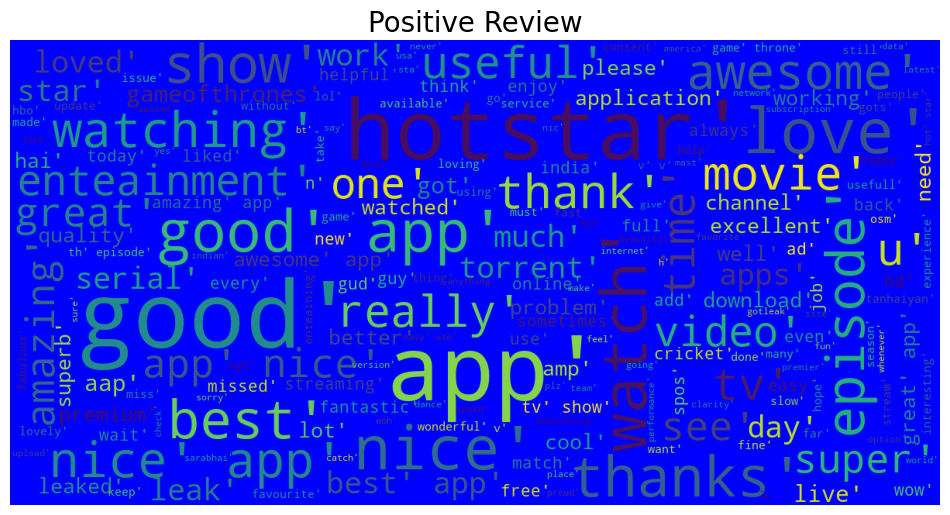

In [88]:
fig =plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_pos)
plt.title("Positive Review",size=20)
plt.show()

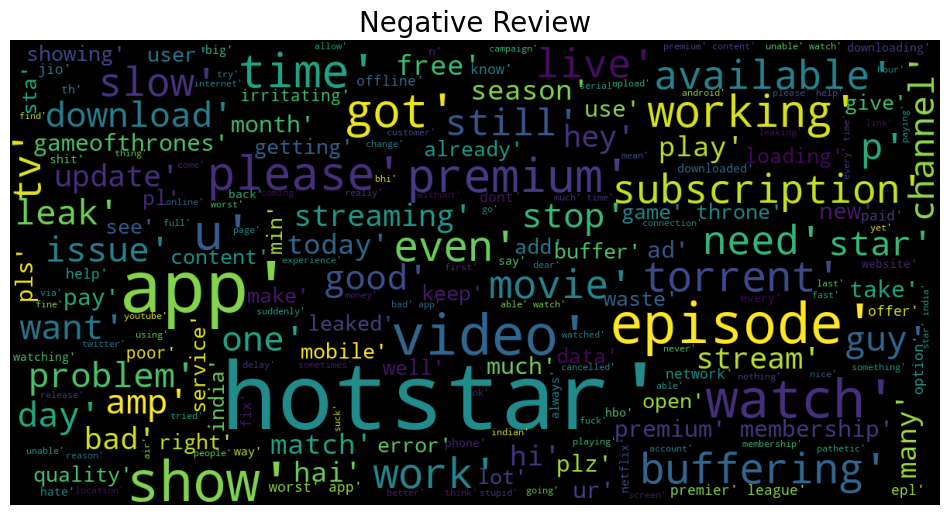

In [89]:
fig =plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neg)
plt.title("Negative Review",size=20)
plt.show()

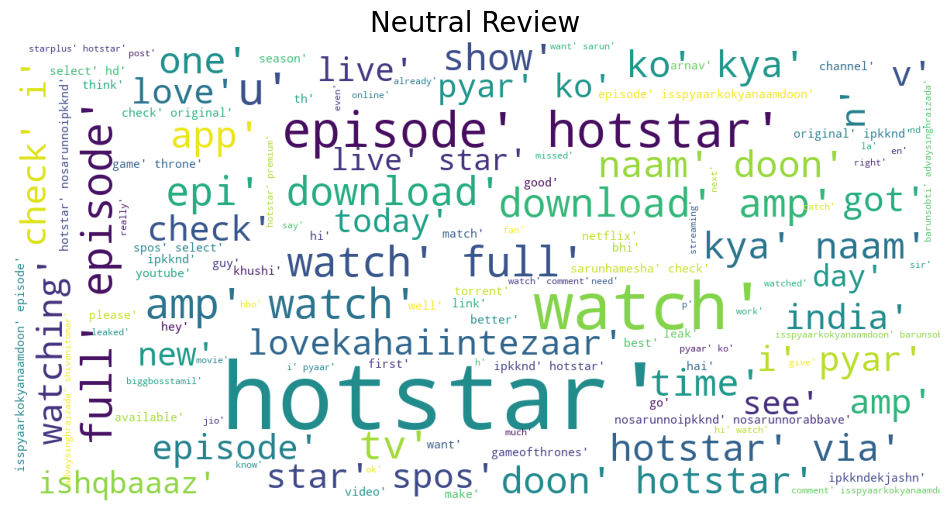

In [90]:
fig =plt.figure(1,figsize=(12,12))
plt.axis('off')
plt.imshow(wordcloud_neu)
plt.title("Neutral Review",size=20)
plt.show()